In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

In [2]:
def getDotList(image, t_lower, t_upper):
    """
    create a list of all dots in the image and remove stains

    :param image: binary image
    :param t_lower: lower threshold of stains to be removed
    :param t_upper: upper threshold of stains to be removed
    :return: list of all centroids without stains [[float, float], [float, float], ... ]
    """ 
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    stain_index = []
    for count, stat in enumerate(stats):
        if stat[4] < t_lower or stat[4] > t_upper:
            stain_index.append(count)
            
    return np.delete(centroids, stain_index, axis=0)

In [3]:
def euclideanDistance(point1, point2):
    """
    calculates the Euclidean distance between two points

    :param point1: point 1 ([float, float])
    :param point2: point 2 ([float, float])
    :return: Euclidean distance (float)
    """ 
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [4]:
def calculateClosestDistance(centroid, other_centroids):
    """
    Calculates the distance to all other points and returns the one with the shortest distance

    :param centroid: initial point ([float, float])
    :param other_centroids: List of all other centroids ([float, float], [float, float], ...)
    :return: [Distance to closest point (float), x-value origin (float), y-value origin (float), 
                x-value closest point (float), y- value closest point (float)]
    """ 
    distances = []
    
    for other_centroid in other_centroids:
        distances.append([euclideanDistance(centroid, other_centroid), 
                          centroid[0], 
                          centroid[1], 
                          other_centroid[0], 
                          other_centroid[1]])

    index_shortest_distance = np.argmin(distances, axis=0)[0]
    shortest_distance = distances[index_shortest_distance]
    
    return shortest_distance

In [5]:
def angleInRadians(angle):
    """
    changeing an angle from degrees to radians
    
    :param angle: angle in degrees (float)
    :return: angle in degrees (float)
    """ 
    return angle * (math.pi / 180.0)

In [6]:
def getNextValue(startValue, length, angle):
    """
    Calculation of the next coordinate when moving a certain length at a certain angle
    
    :param startValue: Coordinates of the this point [float, float]
    :param length: distance to next point (float)
    :param angle: angle of Vektor in radians to next point (float)
    :return: Coordinates of the next point [float, float]
    """ 
    return [(startValue[0] + length * math.cos(angleInRadians(angle))), 
             (startValue[1] + length * math.sin(angleInRadians(angle)))]

In [7]:
def removeDeviations(affectedList, maxDeviation, runs):
    """
    Remove deviations from list to get a more accurate average
    
    :param affectedList: list of values [float, float, ...]
    :param maxDeviation: max Deviation in both directions (float)
    :param runs: number of runs through the process (int)
    :return: more accurate average from list (float)
    """ 
    for i in range(runs):
        temp_list = affectedList
        if not temp_list:
            raise ValueError("empty list")
        else:
            affectedList = []
            average = np.mean(temp_list) 
            
            for value in temp_list:
                if value > (average - maxDeviation) and value < (average + maxDeviation):
                    affectedList.append(value)
         
    return np.mean(affectedList) 

In [8]:
def checkSeperator(mic_mat):
    """
    Checks if the separators of the Xerox-MIC are in the right place
    
    :param mic_mat: Xerox MIC Matrix [int, int, ...]
    :return: Seperator is or is not in the right place (boolean)
    """ 
    # first Seperator
    if (mic_mat[0][8] != 1 
        or mic_mat[1][8] != 0 
        or mic_mat[2][8] != 0 
        or mic_mat[3][8] != 0 
        or mic_mat[4][8] != 0 
        or mic_mat[5][8] != 0 
        or mic_mat[6][8] != 0 
        or mic_mat[7][8] != 0) :
        return False
    # second Seperator
    elif (mic_mat[0][9] != 0
            or mic_mat[1][9] != 1 
            or mic_mat[2][9] != 1 
            or mic_mat[3][9] != 1 
            or mic_mat[4][9] != 1 
            or mic_mat[5][9] != 1 
            or mic_mat[6][9] != 1 
            or mic_mat[7][9] != 1) :
        return False
    else:
        return True

In [9]:
def checkParityRow(row):
    """
    Checks if the parity (first Element) of a row is correct
    
    :param row: row to check [int, int, ...]
    :return: parity bits are or are not set right (boolean)
    """ 
    count = 0
    for bit in row[1:]:
        if bit == 1:
            count = count + 1
    if (count % 2) == row[0]:
        return False
    else:
        return True

In [10]:
def checkParity(matrix):
    """
    Checks if the paritys of a matrix are correct
    
    :param row: matrix to check [[int, int, ...], [...], ...]
    :return: parity bits are or are not set right (boolean)
    """ 
    # check rows
    for row in matrix[1:]:
        if not checkParityRow(row):
            return False

    # check columns
    matrix = np.rot90(matrix)
    for row in matrix:
        if not checkParityRow(row):
            return False
        
    return True

In [11]:
def evaluateColumn(matrix, column):
    """
    evaluates a column of a MIC-Matrix
    
    :param matrix: matrix to evaluate [[int, int, ...], [...], ...]
    :param column: column to evaluate (int)
    :return: result of calculation of column of matrix (int)
    """ 
    return (1  * matrix[7][column] +
            2  * matrix[6][column] +
            4  * matrix[5][column] +
            8  * matrix[4][column] +
            16 * matrix[3][column] +
            32 * matrix[2][column] +
            64 * matrix[1][column])

Time: 12:50
Date: 21. June 2005
Serial: 21052857


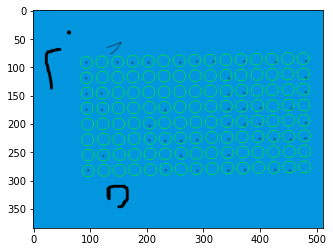

In [12]:
# read image
src = cv2.imread('Bilder/punkte_gerade_Flecken.png', cv2.IMREAD_UNCHANGED)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


#############################
# dot detection
#############################
# Detect dots using canny edge detection
# Syntax: cv2.Canny(image, T_lower, T_upper)
# 
# Where: 
# Image: Input image to which Canny filter will be applied
# T_lower: Lower threshold value in Hysteresis Thresholding
# T_upper: Upper threshold value in Hysteresis Thresholding
edges_image = cv2.Canny(src,90,255)

# Create a list from the recognized dots
edges_image = edges_image.astype('uint8')
centroids = getDotList(edges_image, 5, 15)

# if the picture is upright, rotate it 90 degrees
if ((np.matrix(centroids).max(0)[0, 0] - np.matrix(centroids).min(0)[0, 0]) < 
    (np.matrix(centroids).max(0)[0, 1] - np.matrix(centroids).min(0)[0, 1])):
    src = cv2.rotate(src, cv2.ROTATE_90_COUNTERCLOCKWISE)
    edges_image = np.rot90(edges_image)
    centroids = getDotList(edges_image, 5, 15)

#############################
# grid calculation
#############################

# determine a list containing for each dot the nearest other dot and its coordinates
closest_distances = []

for i in range(len(centroids)):
    other_centroids = np.vstack((centroids[:i], centroids[i+1:]))
    closest_distances.append(calculateClosestDistance(centroids[i], other_centroids))

# Sort the list by length (from shortest to longest)
closest_distances = sorted(closest_distances , key=lambda k: [k[0]])


# calculate the average values of the grid
grid_distance = 0     # Average distance value (median) of the closest dots that are directly next to each other
count_values = 0      # iterations through loop (number of dots which are direclty next to each other)
angles = []           # list of all used angles

for closest_distance_vektor in closest_distances[5:]:
    
    # if larger => no longer direct neighbors => end of loop
    # The fifth value is therefore taken, as the probability is lowest that it is either a downward outlier 
    # or no longer a direct neighbor
    if closest_distance_vektor[0] > (1.3 * closest_distances[5][0]):
        break
        
    # number of values #####################
    count_values = count_values + 1
    
    # calculate distance ###################
    # adding up vektor length (to calculate Average distance value)
    grid_distance = grid_distance + closest_distance_vektor[0]
    
    
    # calculate angle ######################
    # get this vektor 
    # the magnitude is taken from the vector, as you do not know how the vector is rotated
    grid_vektor = [
        (abs(closest_distance_vektor[3]-closest_distance_vektor[1])), 
        (abs(closest_distance_vektor[4]-closest_distance_vektor[2]))
    ]
    
    __x_Axis = [1,0] # "x-axis"
    
    # Calculation of the angle of the vector to the x-axis
    this_angle = np.degrees(np.arccos(np.dot(grid_vektor, __x_Axis) / 
                                      (np.linalg.norm(grid_vektor) * np.linalg.norm(__x_Axis))))
    
    # If the angle is greater than 45 degrees, the grid is tilted downwards
    if this_angle > 45:
        this_angle = abs(this_angle - 90)
    if this_angle > 90 or this_angle < 0:
        raise ValueError("unexpected angle")
        # TO DO: Benutzerausgabe
    
    angles.append(this_angle)

# calculate Averages
if count_values <= 0:
    raise ValueError("empty closest_distances list")
    # TO DO: Benutzerausgabe
else: 
    grid_distance = grid_distance / count_values
    grid_angle = -(removeDeviations(angles, 2, 2))
    

# Getting the starting point (Closest dot to the top left corner is probably the starting point)
startpoint_grid_calc = calculateClosestDistance([0, 0], centroids)

startpoint_grid = [startpoint_grid_calc[3], startpoint_grid_calc[4]]
startpoint_runs = 0 # so we don't get an endless loop
correct_startpoint_found = False

# If another point is higher than the starting point, the grid is tilted upwards, 
# otherwise it is tilted downwards
if startpoint_grid[1] <= np.matrix(centroids).min(0)[0, 1]:
    grid_angle = -grid_angle

# step for each "row"
temp = getNextValue(startpoint_grid, grid_distance, grid_angle)
step_down_horizontal = [-(temp[1] - startpoint_grid[1]), 
                        temp[0] - startpoint_grid[0]]

# step for each "column"
step_down_vertical = [step_down_horizontal[1], -step_down_horizontal[0]]


while(correct_startpoint_found == False and startpoint_runs < 5):
    startpoint_runs = startpoint_runs + 1

    #############################
    # loop through grid
    #############################

    res = src.copy()
    line_color = (0, 255, 0)

    grid_size = [8, 15] # size of MIC Grid
    mic_matrix =  [[0 for _ in range(grid_size[1])] for _ in range(grid_size[0])] # set bits of the MIC
    dot_count = 0 # checks if all dots got found

    startpoint_row = [startpoint_grid[0], startpoint_grid[1]]
    each_dot = [startpoint_row[0], startpoint_row[1]]


    # iterate through each dot in each row
    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            #draw circle
            cv2.circle(res, np.uint16(np.rint(each_dot)), np.uint16(np.rint(grid_distance * 0.4)), line_color, 1)

            # check if a dot is in range
            # if dot is in circle => matrix = 1 , else => matrix = 0 (stays the same)
            distance_to_closest_dot = calculateClosestDistance(each_dot, centroids)
            if distance_to_closest_dot[0] < (grid_distance * 0.4):
                mic_matrix[y][x] = 1
                dot_count = dot_count + 1

            # next dot
            each_dot = [each_dot[0] + step_down_vertical[0], 
                        each_dot[1] + step_down_vertical[1]]
        # next row
        startpoint_row = [startpoint_row[0] + step_down_horizontal[0], 
                          startpoint_row[1] + step_down_horizontal[1]]
        each_dot = [startpoint_row[0], startpoint_row[1]]


    #############################
    # Check grid for correctness
    #############################    
    
    # if not all dots could be assigned
    if dot_count != len(centroids):
        # search whether dots are also one row to the left 
        # => if something is found, then move the grid one row to the left
        # this works because it is not possible to have a completely empty line due to the parity bit
        new_start = [startpoint_grid[0] - step_down_vertical[0], 
                     startpoint_grid[1] - step_down_vertical[1]]
        for x in range(grid_size[1]):
            distance_to_closest_dot = calculateClosestDistance(new_start, centroids)
            if distance_to_closest_dot[0] < (grid_distance * 0.4):
                startpoint_grid[0] = startpoint_grid[0] - step_down_vertical[0] 
                startpoint_grid[1] = startpoint_grid[1] - step_down_vertical[1]
                break
            new_start[0] = new_start[0] + step_down_horizontal[0]
            new_start[1] = new_start[1] + step_down_horizontal[1]
        
        # search whether dots are also one row to the top 
        # => if something is found, then move the grid one row to the top
        new_start = [startpoint_grid[0] - step_down_horizontal[0], 
                     startpoint_grid[1] - step_down_horizontal[1]]
        for y in range(grid_size[0]):
            distance_to_closest_dot = calculateClosestDistance(new_start, centroids)
            if distance_to_closest_dot[0] < (grid_distance * 0.4):
                startpoint_grid[0] = startpoint_grid[0] - step_down_horizontal[0] 
                startpoint_grid[1] = startpoint_grid[1] - step_down_horizontal[1]
                break
            new_start[0] = new_start[0] + step_down_vertical[0]
            new_start[1] = new_start[1] + step_down_vertical[1] 
    else:
        correct_startpoint_found = True

if not correct_startpoint_found:
    raise ValueError("no correct startingpoint found")
    # TO DO: Benutzerausgabe

# check if the separator is in the right place, if not, rotate the image 180 degrees
if not checkSeperator(mic_matrix):
    mic_matrix = np.flipud(mic_matrix)
    mic_matrix = np.fliplr(mic_matrix)
    
    # if the separator is still not found => image was not recognized correctly or it is not a Xerox code
    if not checkSeperator(mic_matrix):
        raise ValueError("no Seperator found")
        # TO DO: Ausgabe an Gerät

# Check parity bits
if not checkParity(mic_matrix):
    raise ValueError("faulty bits")
    # TO DO: Ausgabe an Gerät

        
#############################
# Evaluation of the grid
#############################

__month_array = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

minutes = evaluateColumn(mic_matrix, 1)
hour    = evaluateColumn(mic_matrix, 4)
print_time = str(hour) + str(":") + str(minutes)

day     = evaluateColumn(mic_matrix, 5)
month   = evaluateColumn(mic_matrix, 6)
year    = evaluateColumn(mic_matrix, 7)
print_date = str(day) + ". " + str(__month_array[month-1]) + " 2" + str(year).zfill(3)

print_serial  = (str(evaluateColumn(mic_matrix, 13)).zfill(2) +
           str(evaluateColumn(mic_matrix, 12)).zfill(2) +
           str(evaluateColumn(mic_matrix, 11)).zfill(2) +
           str(evaluateColumn(mic_matrix, 10)).zfill(2))

print("Time:", print_time)
print("Date:", print_date)
print("Serial:", print_serial)
    

# display the image
cv2.imwrite('DrawGridTestImage.png',res)
plt.imshow(res)